# MSIN0166: Data Engineering
________________________
# Individual Coursework:
________________________

## PotterPal
PotterPal, your wizarding buddy, is an AI chatbot created with Langchain technology. It excels in answering questions about the Harry Potter series, employing dynamic RAG pipelines, diverse language models, FAISS for speedy text retrieval, and Gradio for an interactive chat interface.


### Word Count - 3758 Words
### Candidate Number - FYWN5

  
________________________



#### Link for GitHub Repository:
https://github.com/ankitmehani/RAG_Based_LLM-DE_Individual_Project


# Table of Contents:
_________________________________
* [1. Overview](#Bullet1)
* [2. Models](#Bullet2)
* [3. Installs](#Bullet3)  
* [4. Imports](#Bullet4)  
* [5. CFG](#Bullet5)  
* [6. Define Model](#Bullet6)  
* [7. Pipeline](#Bullet7)  
* [8. Langchain](#Bullet8)
* [9. Loader](#Bullet9)
* [10. Splitter](#Bullet10)
* [11. Create Embeddings](#Bullet11)
* [12. Load vector database](#Bullet12)
* [13. Prompt Template](#Bullet13)
* [14. Retriever Chain](#Bullet14)
* [15. Post-process outputs](#Bullet15)
* [16. Ask questions](#Bullet16)
* [17. Gradio Chat UI](#Bullet17)
* [18. Conclusions](#Bullet18)
* [19. Appendix and logs](#Bullet19)

# 1. Overview <a class="anchor" id="Bullet1"></a>

- Use Langchain to build a chatbot that can answer questions about Harry Potter books
- Flexible and customizable RAG pipeline (Retrieval Augmented Generation)
- Experiment with various LLMs (Large Language Models)
- Use FAISS vector store to store text embeddings created with Sentence Transformers from 🤗. FAISS runs on GPU and it is much faster than Chroma
- Use Retrieval chain to retrieve relevant passages from embedded text
- Summarize retrieved passages
- Leverage Colab GPU ( T4) with Hugging Face Accelerate
- Chat UI with Gradio


# 2. Models <a class="anchor" id="Bullet2"></a>
- TheBloke/wizardLM-7B-HF
- daryl149/llama-2-7b-chat-hf
- daryl149/llama-2-13b-chat-hf
- mistralai/Mistral-7B-Instruct-v0.2

Below code will allows us to access files stored in your Google Drive directly from a Colab notebook, facilitating seamless integration of data stored in Google Drive with Colab workflow

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


RAG_Architecture

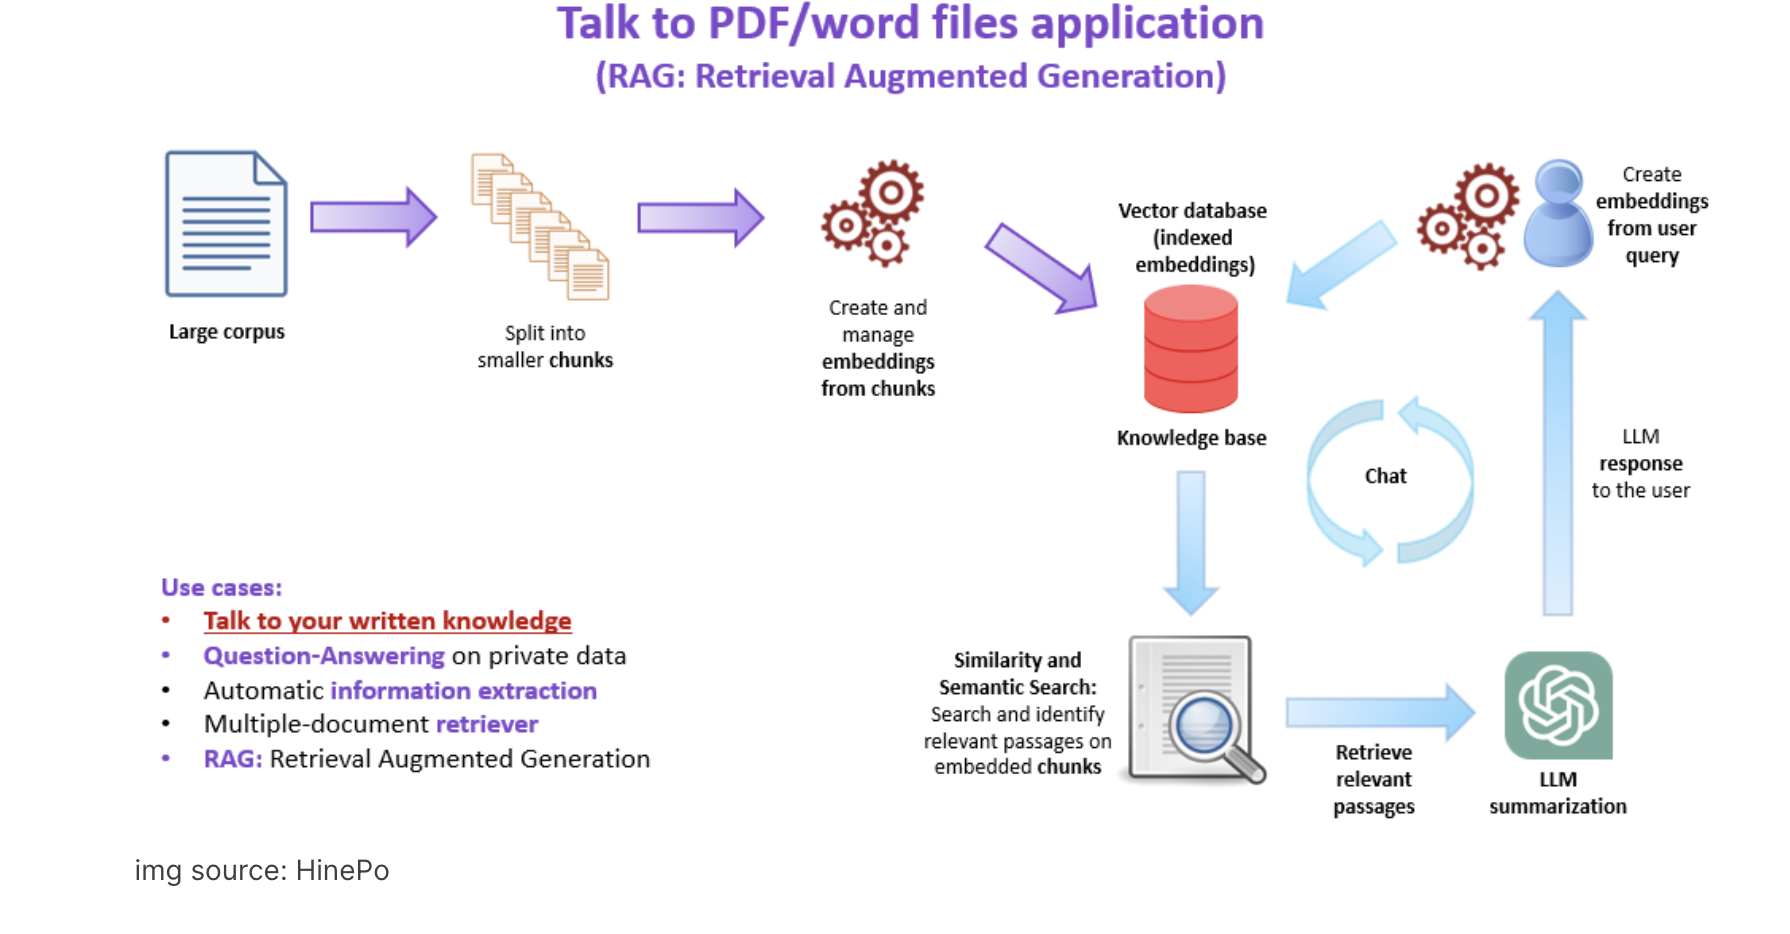

In [3]:
from IPython.display import display
from PIL import Image

# Path to the image file in your Google Drive
image_path = 
'/content/drive/MyDrive/DE_Individual_Project/RAG_Architecture.png'

# Open the image file
image = Image.open(image_path)


# Display the image using IPython display
display(image)


# 3. Installs <a class="anchor" id="Bullet3"></a>

In [4]:
# Path to your Google Drive
import os
google_drive_path = '/content/drive/MyDrive/DE_Individual_Project/'



files = os.listdir(google_drive_path)


# Print the list of files and directories
print("Files and directories in your Google Drive:")
for file in files:
    print(file)

Files and directories in your Google Drive:
RAG_Architecture.png
harry-potter-vectordb
input
Output
books


Upload aws_config.ini containing AWS credentials, file is being kept in local drive for security purposes

In [5]:
import os
from google.colab import files

# Check if the file already exists
if 'aws_config.ini' in os.listdir('.'):
    print('aws_config.ini already exists in the current directory.'
          'No need to upload.')

else:
    # Upload the aws_config.ini file into Google Drive
    uploaded = files.upload()

    # Check if the file was uploaded successfully
    if 'aws_config.ini' in uploaded:
        print('aws_config.ini uploaded successfully!')
    else:
        print('Upload failed.'
              'Please make sure the file is selected and try again.')


Saving aws_config.ini to aws_config.ini
aws_config.ini uploaded successfully!


Retrive AWS Credentials and set environment variables.

In [6]:
# Import necessary libraries
import configparser
import os

# Initialize the configuration parser
config = configparser.ConfigParser()

# Specify the path to your configuration file
config_file_path = 'aws_config.ini'  # Make sure the file is uploaded to Colab

# Read the configuration file
config.read(config_file_path)

# Access AWS credentials
aws_region = config.get('aws', 'region')
aws_access_key_id = config.get('aws', 'access_key_id')
aws_secret_access_key = config.get('aws', 'secret_access_key')

# Set environment variables
os.environ["AWS_DEFAULT_REGION"] = aws_region
os.environ["AWS_ACCESS_KEY_ID"] = aws_access_key_id
os.environ["AWS_SECRET_ACCESS_KEY"] = aws_secret_access_key



Install necessary packages

In [7]:
%%time

from IPython.display import clear_output

! pip install sentence_transformers==2.2.2

! pip install -qq -U langchain
! pip install -qq -U tiktoken
! pip install -qq -U pypdf
! pip install -qq -U faiss-gpu
! pip install -qq -U InstructorEmbedding

! pip install -qq -U transformers
! pip install -qq -U accelerate
! pip install -qq -U bitsandbytes
! pip install configparser
! pip install boto3


clear_output()

CPU times: user 1.2 s, sys: 195 ms, total: 1.4 s
Wall time: 2min 54s


# 4. Imports <a class="anchor" id="Bullet4"></a>

In [8]:
%%time

import warnings
warnings.filterwarnings("ignore")

import boto3
import glob
import textwrap
import time

import langchain

### loaders
from langchain.document_loaders import PyPDFLoader, DirectoryLoader

### splits
from langchain.text_splitter import RecursiveCharacterTextSplitter

### prompts
from langchain import PromptTemplate, LLMChain

### vector stores
from langchain.vectorstores import FAISS

### models
from langchain.llms import HuggingFacePipeline
from langchain.embeddings import HuggingFaceInstructEmbeddings

### retrievers
from langchain.chains import RetrievalQA

import torch
import transformers
from transformers import (
    AutoTokenizer, AutoModelForCausalLM,
    BitsAndBytesConfig,
    pipeline
)

clear_output()

CPU times: user 8.65 s, sys: 1.26 s, total: 9.9 s
Wall time: 17.5 s


In [9]:
print('langchain:', langchain.__version__)
print('torch:', torch.__version__)
print('transformers:', transformers.__version__)

langchain: 0.1.16
torch: 2.2.1+cu121
transformers: 4.39.3


Below code will download all books from s3 bucket - hpbooks into colab library - /content/drive/MyDrive/DE_Individual_Project/books/ (If directory is not created will create new directory)

In [10]:
# Initialize S3 client
s3_client = boto3.client(
    service_name='s3',
    region_name=aws_region,
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key
)

# Specify the bucket name
bucket_name = 'hpbooks'

# Directory to save downloaded books
download_dir = '/content/drive/MyDrive/DE_Individual_Project/books/'

# Create the directory if it doesn't exist
os.makedirs(download_dir, exist_ok=True)

# List objects in the bucket
objects = s3_client.list_objects_v2(Bucket=bucket_name)

# Check if the bucket contains any objects
if 'Contents' in objects:
    # Retrieve keys (file paths) of the objects
    keys = [obj['Key'] for obj in objects['Contents']]

    # Download each book from S3 bucket
    for key in keys:
        # Define local file path for the downloaded book
        local_file_path = os.path.join(download_dir, 
                                       os.path.basename(key))

        # Download the book from S3 bucket
        s3_client.download_file(bucket_name, key, 
                                local_file_path)

        print(f"Downloaded {key} to {local_file_path}")
else:
    print("No objects found in the bucket.")


Downloaded HP1 - Harry Potter and the Sorcerer_s Stone.pdf to /content/drive/MyDrive/DE_Individual_Project/books/HP1 - Harry Potter and the Sorcerer_s Stone.pdf
Downloaded HP2 - Harry Potter and the Chamber of Secrets.pdf to /content/drive/MyDrive/DE_Individual_Project/books/HP2 - Harry Potter and the Chamber of Secrets.pdf
Downloaded HP3 - Harry Potter and the Prisoner of Azkaban.pdf to /content/drive/MyDrive/DE_Individual_Project/books/HP3 - Harry Potter and the Prisoner of Azkaban.pdf
Downloaded HP4 - Harry Potter and the Goblet of Fire.pdf to /content/drive/MyDrive/DE_Individual_Project/books/HP4 - Harry Potter and the Goblet of Fire.pdf
Downloaded HP5 - Harry Potter and the Order of the Phoenix.pdf to /content/drive/MyDrive/DE_Individual_Project/books/HP5 - Harry Potter and the Order of the Phoenix.pdf
Downloaded HP6 - Harry Potter and the Half-Blood Prince.pdf to /content/drive/MyDrive/DE_Individual_Project/books/HP6 - Harry Potter and the Half-Blood Prince.pdf
Downloaded HP7 - H

S3 Bucket

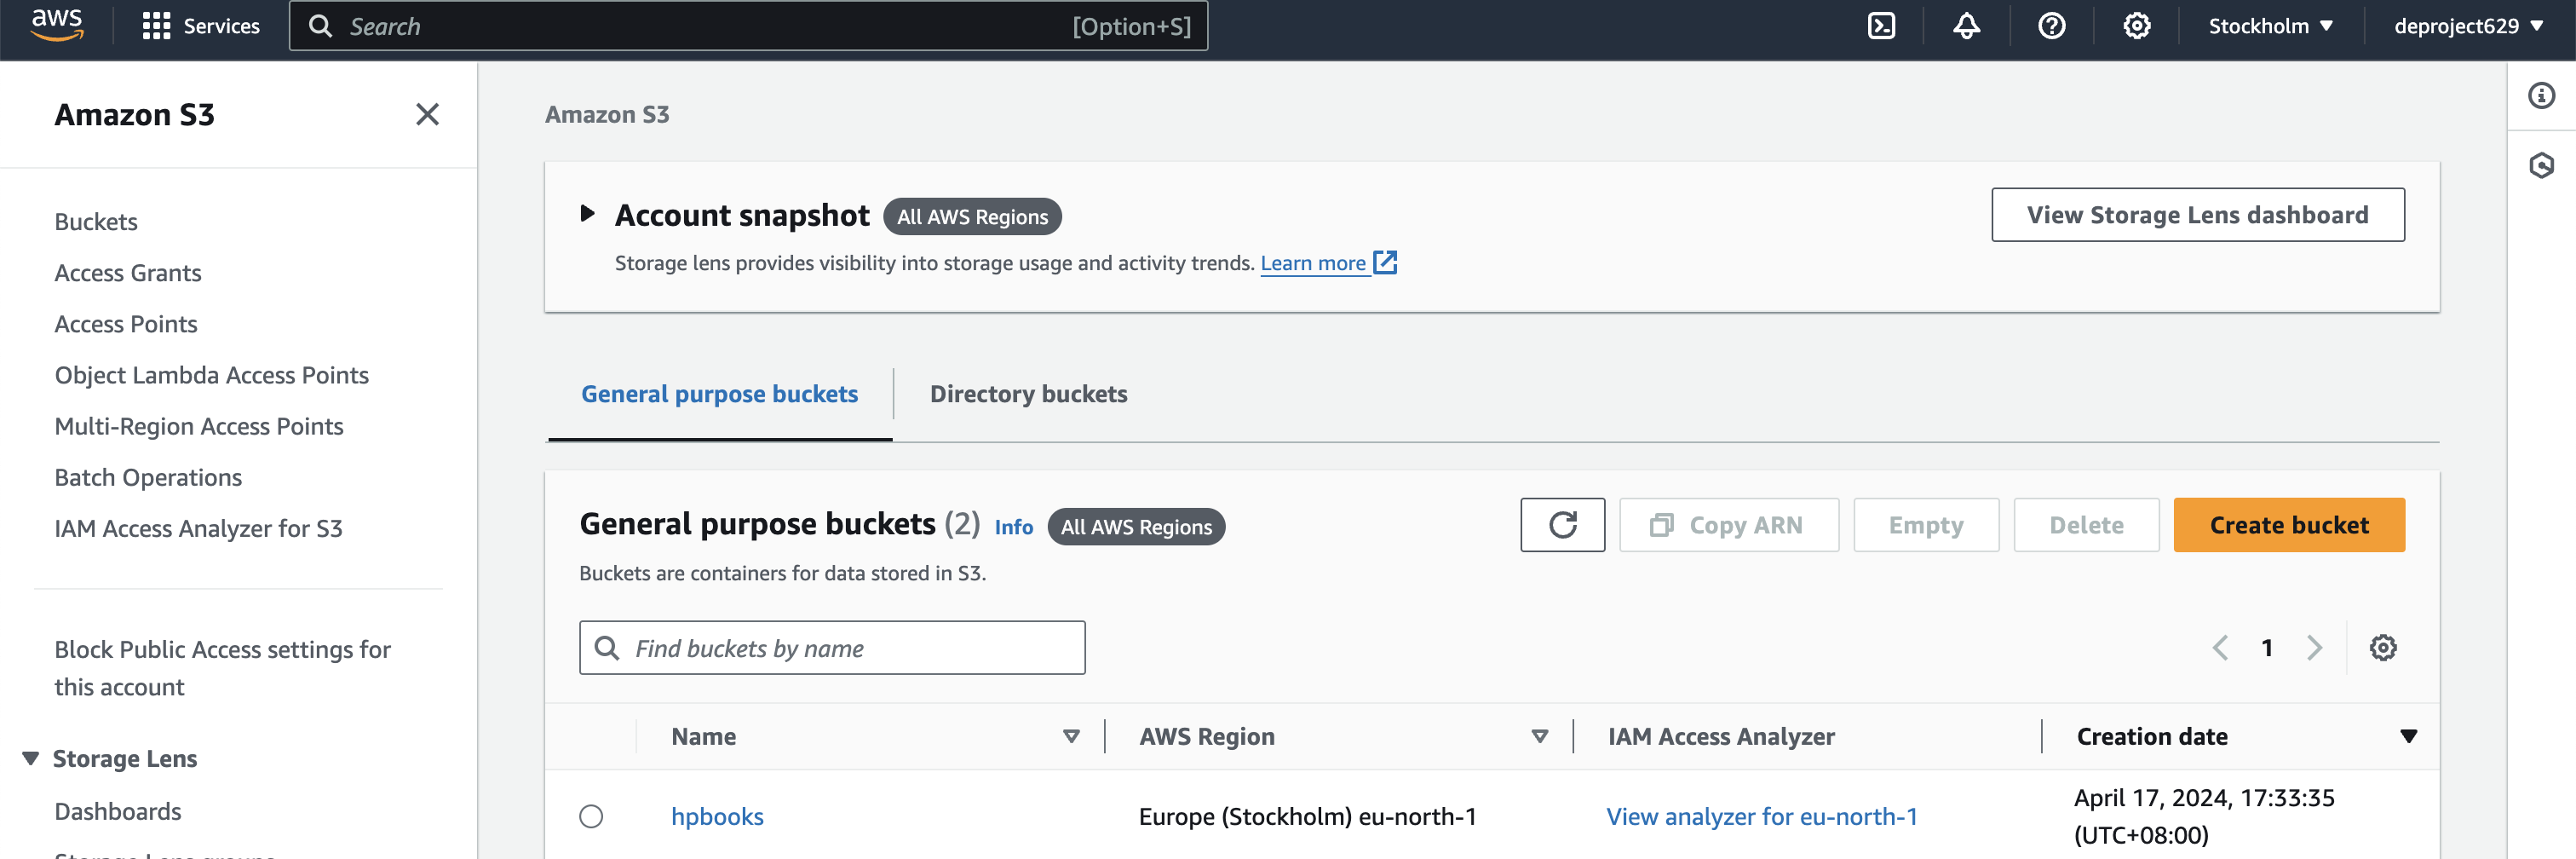

In [11]:
from IPython.display import display

# Path to the image file in your Google Drive
image_path = 
'/content/drive/MyDrive/DE_Individual_Project/input/AWS_hpbooks.png'

# Open the image file
image = Image.open(image_path)


# Display the image using IPython display
display(image)


S3 Bucket Contents (Books in Bucket - hpbooks)

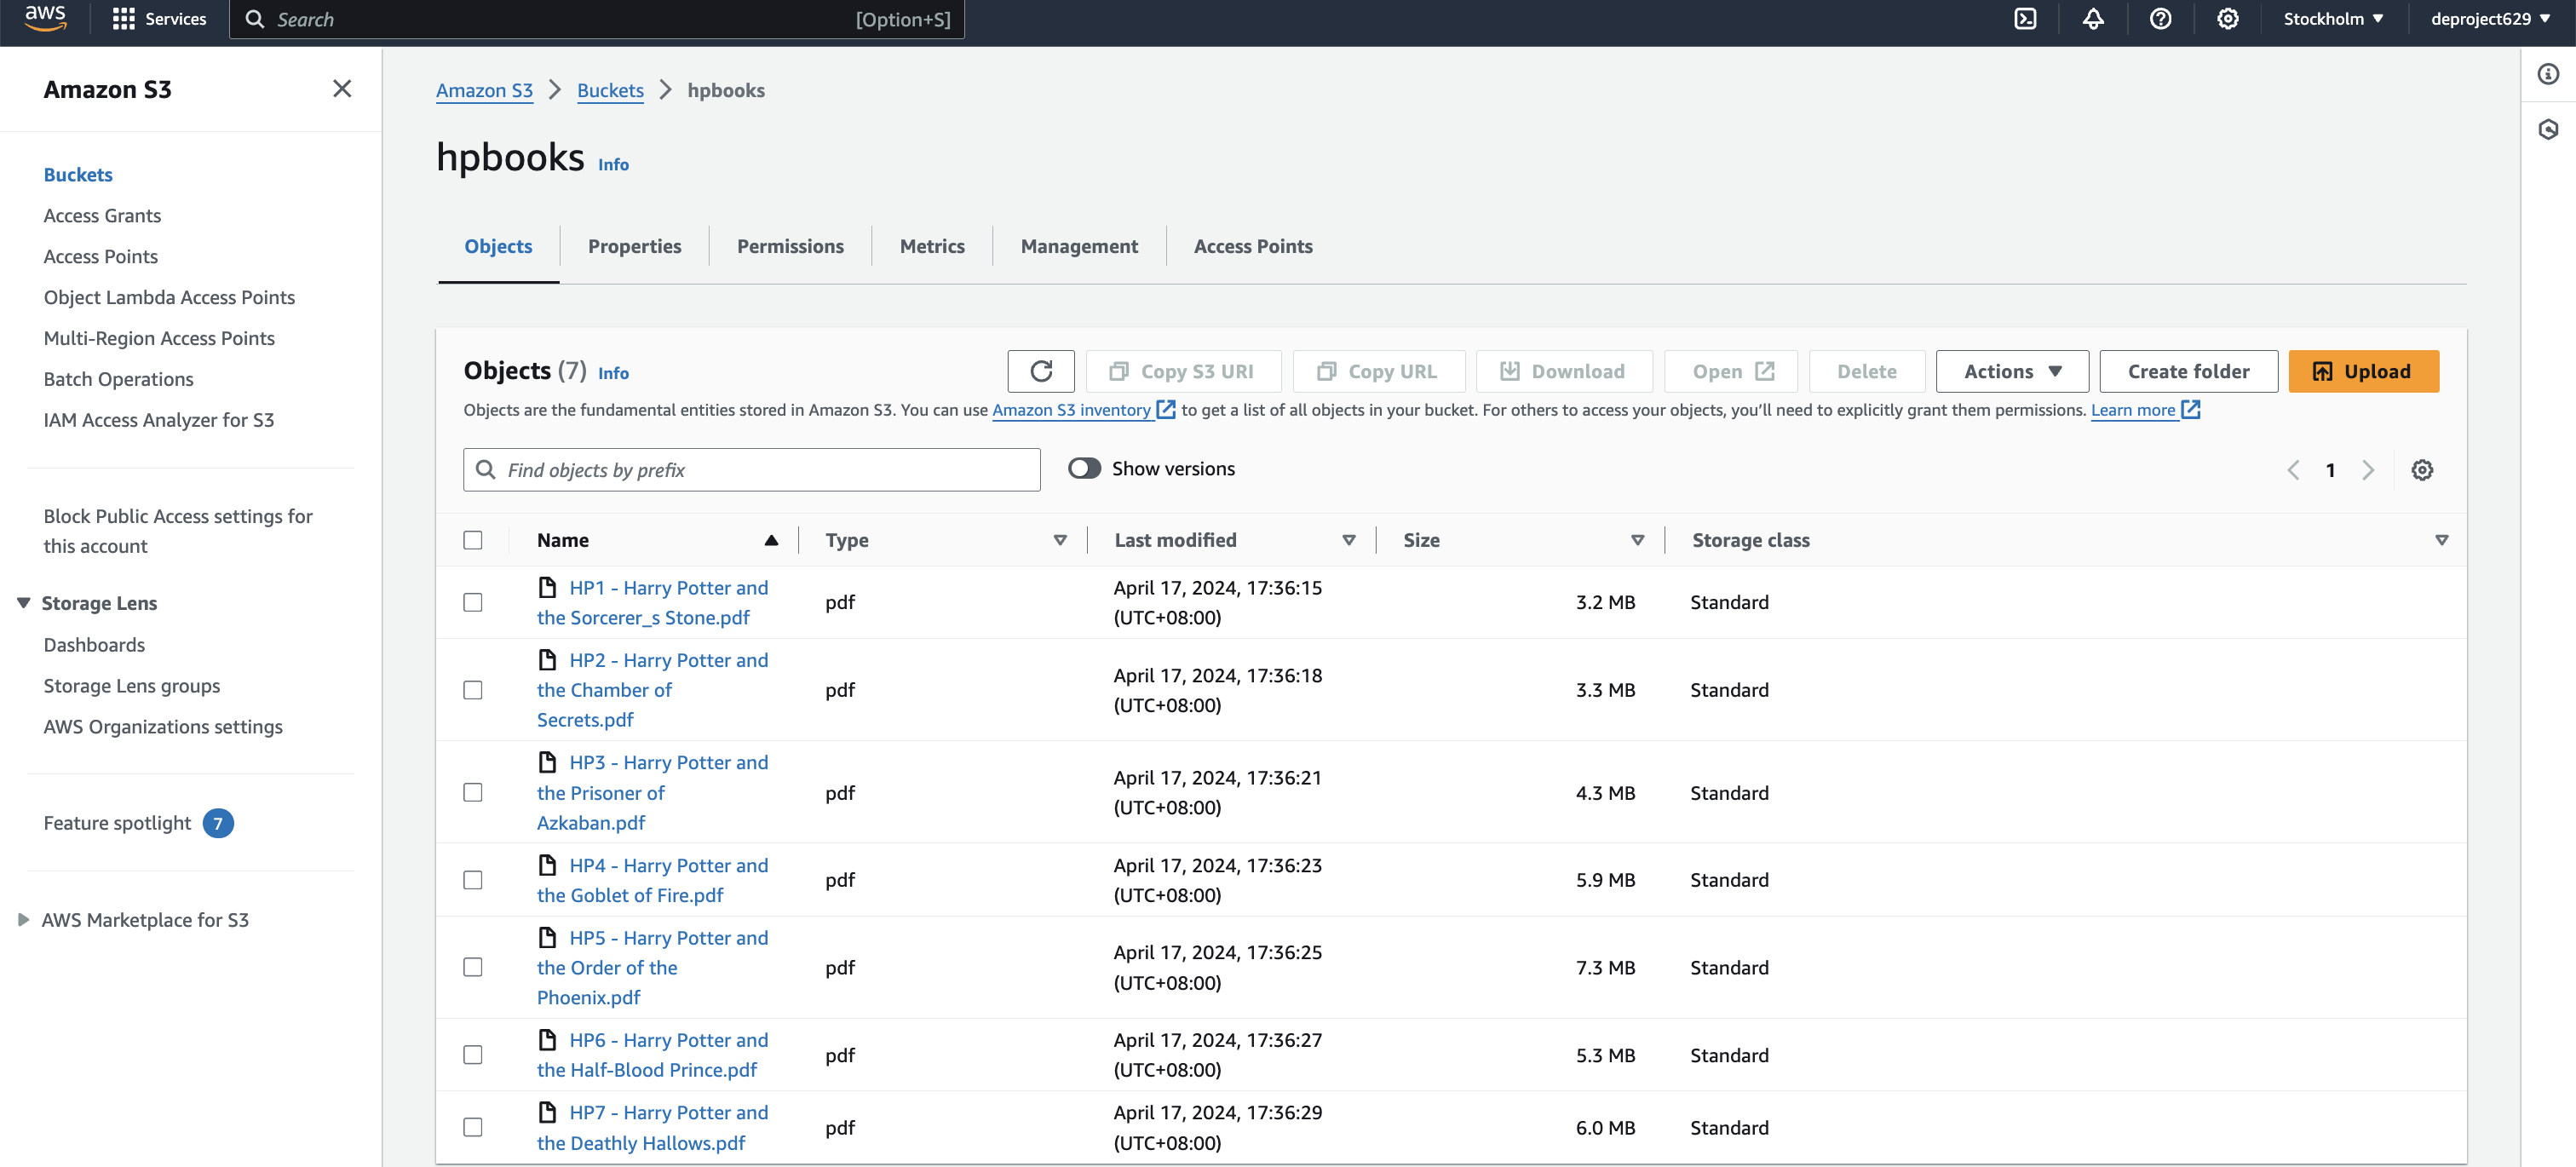

In [12]:
from IPython.display import display

# Path to the image file in your Google Drive
image_path = 
'/content/drive/MyDrive/DE_Individual_Project/input/AWS_hpbooks_contents.png'

# Open the image file
image = Image.open(image_path)


# Display the image using IPython display
display(image)


In [13]:
sorted(glob.glob(
    '/content/drive/MyDrive/DE_Individual_Project/books/*'))

['/content/drive/MyDrive/DE_Individual_Project/books/HP1 - Harry Potter and the Sorcerer_s Stone.pdf',
 '/content/drive/MyDrive/DE_Individual_Project/books/HP2 - Harry Potter and the Chamber of Secrets.pdf',
 '/content/drive/MyDrive/DE_Individual_Project/books/HP3 - Harry Potter and the Prisoner of Azkaban.pdf',
 '/content/drive/MyDrive/DE_Individual_Project/books/HP4 - Harry Potter and the Goblet of Fire.pdf',
 '/content/drive/MyDrive/DE_Individual_Project/books/HP5 - Harry Potter and the Order of the Phoenix.pdf',
 '/content/drive/MyDrive/DE_Individual_Project/books/HP6 - Harry Potter and the Half-Blood Prince.pdf',
 '/content/drive/MyDrive/DE_Individual_Project/books/HP7 - Harry Potter and the Deathly Hallows.pdf']

# 5. CFG <a class="anchor" id="Bullet5"></a>
- CFG class enables easy and organized experimentation

 The CFG class encapsulates various configuration parameters essential for configuring and fine-tuning the behavior of the chatbot or text processing system, including LLM settings, text splitting parameters, embeddings model, and file paths for input and output storage.





In [14]:
class CFG:
    # LLMs
    model_name = 'llama2-13b-chat' # wizardlm, llama2-7b-chat, llama2-13b-chat, mistral-7B
    temperature = 0
    top_p = 0.95
    repetition_penalty = 1.15

    # splitting
    split_chunk_size = 800
    split_overlap = 0

    # embeddings
    embeddings_model_repo = 'sentence-transformers/all-MiniLM-L6-v2'

    # similar passages
    k = 6

    # paths
    PDFs_path = 
    '/content/drive/MyDrive/DE_Individual_Project/books/'
    Embeddings_path =  
    '/content/drive/MyDrive/DE_Individual_Project/input/faiss-hp-sentence-transformers'
    Output_folder = 
    '/content/drive/MyDrive/DE_Individual_Project/harry-potter-vectordb'

# 6. Define model <a class="anchor" id="Bullet6"></a>

This function, get_model, retrieves pre-trained language models (LLMs) based on the specified model name. It selects the model repository, tokenizer, and settings for different models. It takes an optional model argument (defaulting to CFG.model_name), downloads the corresponding LLM, configures the tokenizer and model, and sets specific parameters like max_len. Finally, it returns the configured tokenizer, model, and max_len.

In [15]:
def get_model(model = CFG.model_name):

    print('\nDownloading model: ', model, '\n\n')

    if model == 'wizardlm':
        model_repo = 'TheBloke/wizardLM-7B-HF'

        tokenizer = 
        AutoTokenizer.from_pretrained(model_repo)

        bnb_config = BitsAndBytesConfig(
            load_in_4bit = True,
            bnb_4bit_quant_type = "nf4",
            bnb_4bit_compute_dtype = torch.float16,
            bnb_4bit_use_double_quant = True,
        )

        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            quantization_config = bnb_config,
            device_map = 'auto',
            low_cpu_mem_usage = True
        )

        max_len = 1024

    elif model == 'llama2-7b-chat':
        model_repo = 'daryl149/llama-2-7b-chat-hf'

        tokenizer = 
        AutoTokenizer.from_pretrained(model_repo, use_fast=True)

        bnb_config = BitsAndBytesConfig(
            load_in_4bit = True,
            bnb_4bit_quant_type = "nf4",
            bnb_4bit_compute_dtype = torch.float16,
            bnb_4bit_use_double_quant = True,
        )

        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            quantization_config = bnb_config,
            device_map = 'auto',
            low_cpu_mem_usage = True,
            trust_remote_code = True
        )

        max_len = 2048

    elif model == 'llama2-13b-chat':
        model_repo = 'daryl149/llama-2-13b-chat-hf'

        tokenizer = 
        AutoTokenizer.from_pretrained(model_repo, use_fast=True)

        bnb_config = BitsAndBytesConfig(
            load_in_4bit = True,
            bnb_4bit_quant_type = "nf4",
            bnb_4bit_compute_dtype = torch.float16,
            bnb_4bit_use_double_quant = True,
        )

        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            quantization_config = bnb_config,
            device_map = 'auto',
            low_cpu_mem_usage = True,
            trust_remote_code = True
        )

        max_len = 2048 # 8192

    elif model == 'mistral-7B':
        model_repo = 'mistralai/Mistral-7B-v0.1'

        tokenizer = 
        AutoTokenizer.from_pretrained(model_repo)

        bnb_config = BitsAndBytesConfig(
            load_in_4bit = True,
            bnb_4bit_quant_type = "nf4",
            bnb_4bit_compute_dtype = torch.float16,
            bnb_4bit_use_double_quant = True,
        )

        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            quantization_config = bnb_config,
            device_map = 'auto',
            low_cpu_mem_usage = True,
        )

        max_len = 1024

    else:
        print("Not implemented model (tokenizer and backbone)")

    return tokenizer, model, max_len

This line of code calls the `get_model` function, which retrieves a pre-trained language model, tokenizer, and maximum sequence length based on the specified model name from the `CFG` class. The function configures the selected model and its tokenizer and returns them, along with the maximum sequence length, which are then assigned to the variables `tokenizer`, `model`, and `max_len`, respectively.


Execute below with T4 GPU else will fail.

In [16]:
%%time

tokenizer, model, max_len = get_model(model = CFG.model_name)

clear_output()

CPU times: user 54.9 s, sys: 1min 3s, total: 1min 58s
Wall time: 14min 8s


Evaluate model

In [17]:
model.eval()

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 5120, padding_idx=0)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear4bit(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )


# 7. Pipeline 🤗 <a class="anchor" id="Bullet7"></a>
- Hugging Face **Pipeline**

The provided code initializes a text generation pipeline using Hugging Face's pipeline function. This pipeline is configured for text generation with parameters such as model, tokenizer, maximum length, temperature, top-p sampling, and repetition penalty, sourced from the CFG class.

Subsequently, a Langchain pipeline (llm) is instantiated, encapsulating the Hugging Face text generation pipeline for potential integration with Langchain functionalities.

In [18]:
### hugging face pipeline
pipe = pipeline(
    task = "text-generation",
    model = model,
    tokenizer = tokenizer,
    pad_token_id = tokenizer.eos_token_id,
#     do_sample = True,
    max_length = max_len,
    temperature = CFG.temperature,
    top_p = CFG.top_p,
    repetition_penalty = CFG.repetition_penalty
)

### langchain pipeline
llm = HuggingFacePipeline(pipeline = pipe)

In [19]:
llm

HuggingFacePipeline(pipeline=<transformers.pipelines.text_generation.TextGenerationPipeline object at 0x7d68c0d80040>)

llm.invoke(query): Invokes the Langchain pipeline (llm) to generate a response to the query. The generated response is not necessarily related to Harry Potter, as the model is being tested without using Harry Potter books as input.

In [20]:
%%time
### testing model, not using the harry potter books yet
### answer is not necessarily related to harry potter
query = "Give me 5 examples of cool potions and explain what they do"
llm.invoke(query)

CPU times: user 43.2 s, sys: 265 ms, total: 43.5 s
Wall time: 51.7 s


'Give me 5 examples of cool potions and explain what they do.\n\nSure thing! Here are five examples of cool potions that you might find in a fantasy world, along with their effects:\n\n1. Potion of Healing: This potion restores health to the drinker, healing wounds and injuries. It might also grant temporary immunity to future damage or disease.\n2. Potion of Strength: This potion grants the drinker increased physical strength and endurance for a short period of time, allowing them to lift heavier objects, run faster, and fight longer.\n3. Potion of Speed: This potion allows the drinker to move at incredible speeds for a short period of time, making it easier to escape danger or chase down enemies.\n4. Potion of Invisibility: This potion makes the drinker temporarily invisible, allowing them to sneak past guards, avoid detection by monsters, or steal valuable items without being caught.\n5. Potion of Flight: This potion gives the drinker the ability to fly for a short period of time, a

# 8. Langchain 🦜🔗 <a class="anchor" id="Bullet8"></a>
- Multiple document retriever with LangChain

In [21]:
CFG.model_name

'llama2-13b-chat'

# 9. Loader <a class="anchor" id="Bullet9"></a>

- A utility for loading files from directories
- This step isn't required if you're only loading the vector database
- However, if you're generating embeddings, it becomes essential. Here's the process:
   - Load PDF files and split them into smaller chunks
   - Generate embeddings from the chunks
   - Store the embeddings in a vector database
   - Once stored, you can directly load the embeddings for similarity search with user queries, followed by using the language model to respond to queries.

This code segment initializes a DirectoryLoader object named loader, configured to load PDF documents from the directory specified by CFG.PDFs_path. It uses the PyPDFLoader class to handle the loading process, displays progress during loading, and employs multithreading for faster execution

The load() method is then called on the loader object to load the documents from the specified directory, and the loaded documents are stored in the variable documents.

In [49]:
%%time

from langchain_community.document_loaders.directory 
import DirectoryLoader

# Assuming CFG.PDFs_path contains the directory path 
#where your PDF files are located

pdf_directory = CFG.PDFs_path

loader = DirectoryLoader(
    pdf_directory,
    loader_cls=PyPDFLoader,
    show_progress=True,
    use_multithreading=True
)

documents = loader.load()


100%|██████████| 7/7 [01:02<00:00,  8.88s/it]

CPU times: user 58.4 s, sys: 875 ms, total: 59.3 s
Wall time: 1min 2s


In [50]:
print(f'We have {len(documents)} pages in total')

We have 4239 books in total


In [67]:
documents[7].page_content



"For Jessica, who loves stories \nfor Anne, who loved them too; and for Di, who heard this one first. \n \nText copyright © 1997 by J.K. Rowling \nIllustrations by Mary GrandPr é copyright © 1998 Warner Bros. \nAll rights reserved. Published by Scholastic  Press, a division of Scholastic Inc., \nPublishers since 1920  \nSCHOLASTIC , SCHOLASTIC PRESS , and the LANTERN LOGO  \nare trademarks and/or registered trademarks of Scholastic Inc. \n \nHARRY POTTER  and all related characters and elements are trademarks of Warner Bros. \n \nNo part of this publication may be reproduced, or stored in a retrieva l system, or transmitted \nin any form or by any means, electronic, mech anical, photocopying, recording, or otherwise, \nwithout written permission of the publisher. For information regarding permissions, write \nto Scholastic Inc., Attention: Permission s Department, 555 Broadway, New York, NY 10012. \n \nLibrary of Congress Cataloging-in-Publication Data \n \nRowling, J.K. \nHarry Potter

# 10. Splitter <a class="anchor" id="Bullet10"></a>
- Splitting the text into chunks so its passages are easily searchable for similarity
- This step is also only necessary if you are creating the embeddings
- RecursiveCharacterTextSplitter

# 11. Create Embeddings <a class="anchor" id="Bullet11"></a>

- Embed and store the texts in a Vector database (FAISS)
- [LangChain Vector Stores docs](https://langchain.readthedocs.io/en/latest/vector_stores.html)
- [FAISS - langchain](https://github.com/facebookresearch/faiss)
- [Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks - paper Aug/2019](https://arxiv.org/abs/1908.10084)


- If you use FAISS vector store on GPU it will take just ~3 min


We need to create the embeddings only once, and then we can just load the vector store and query the database using similarity search.




In [70]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = CFG.split_chunk_size,
    chunk_overlap = CFG.split_overlap
)

texts = text_splitter.split_documents(documents)

print(
    f'We have created {len(texts)} chunks from {len(documents)} pages')

We have created 10903 chunks from 4239 pages


Above code will splits documents into smaller text chunks using a recursive character-based text splitter. This can be useful for various text processing tasks, such as indexing, summarization, or further analysis.

# 12. Load vector database <a class="anchor" id="Bullet12"></a>
 - After saving the vector database, we need to load from google drive or database we will be saving input embedding path.

- Obviously, the embeddings function to load the embeddings must be the same as the one used to create the embeddings

In [71]:
%%time

### we create the embeddings only if they do not exist yet
if not os.path.exists(CFG.Embeddings_path + '/index.faiss'):

    ### download embeddings model
    embeddings = HuggingFaceInstructEmbeddings(
        model_name = CFG.embeddings_model_repo,
        model_kwargs = {"device": "cuda"}
    )

    ### create embeddings and DB
    vectordb = FAISS.from_documents(
        documents = texts,
        embedding = embeddings
    )

    ### persist vector database
    vectordb.save_local(f"{CFG.Output_folder}/faiss_index_hp") 
    # save in output folder
    vectordb.save_local(f"{CFG.Embeddings_path}/faiss_index_hp") 
    # save in input folder

.gitattributes:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

load INSTRUCTOR_Transformer
max_seq_length  512
CPU times: user 30.2 s, sys: 649 ms, total: 30.9 s
Wall time: 38.1 s


Below code loads a local vector database stored in a file using the FAISS library, enabling dangerous deserialization. It initializes an embedding model, sets a flag to allow dangerous deserialization, and then loads the vector database with the specified model and deserialization settings.

In [72]:
import os
from langchain_community.vectorstores.faiss import FAISS

embeddings = HuggingFaceInstructEmbeddings(
    model_name = CFG.embeddings_model_repo,
    model_kwargs = {"device": "cuda"}
)

# Set the flag to allow dangerous deserialization
allow_dangerous_deserialization = True

# Load local vector database with dangerous deserialization enabled
vectordb = FAISS.load_local(
    CFG.Embeddings_path + '/faiss_index_hp',
    embeddings,  # Assuming `embeddings` is an Embeddings object
    allow_dangerous_deserialization=allow_dangerous_deserialization
)




load INSTRUCTOR_Transformer
max_seq_length  512


In [73]:
### test if vector DB was loaded correctly
vectordb.similarity_search('magic creatures')

[Document(page_content='says Draco Malfoy, a fourth-year student. “We all hate Hagrid, but we’re just too scared to say \nanything.” \nHagrid has no intention of ceasing his campaign \nof intimidation, however. In conversation with a \nDaily Prophet  reporter last month, he admitted \nbreeding creatures he has dubbed “Blast-Ended \nSkrewts,” highly dangerous crosses between manti-\ncores and fire-crabs. The creation of new breeds of magical creature is, of course, an activity usually \nclosely observed by the Department for the Regu-\nlation and Control of Magical Creatures. Hagrid, however, considers himself to be above such petty \nrestrictions.', metadata={'source': '/content/drive/MyDrive/DE_Individual_Project/books/HP4 - Harry Potter and the Goblet of Fire.pdf', 'page': 453}),
 Document(page_content='but I’ve heard stuff about charms wearing off cloaks when they get \nold, or them being ripped apart by spells so they’ve got holes in.', metadata={'source': '/content/drive/MyDrive/D

# 13. Prompt Template <a class="anchor" id="Bullet13"></a>
- Custom prompt

This code defines a prompt template using a multi-line string (prompt_template). The template includes placeholders for context and question variables. It then initializes a PromptTemplate object named PROMPT with the provided template and specifies the input variables that should be substituted into the template.

In [74]:
prompt_template = """
Don't try to make up an answer, if you don't know just 
say that you don't know.
Answer in the same language the question was asked.
Use only the following pieces of context 
to answer the question at the end.

{context}

Question: {question}
Answer:"""


PROMPT = PromptTemplate(
    template = prompt_template,
    input_variables = ["context", "question"]
)

# 14. Retriever chain <a class="anchor" id="Bullet14"></a>
- Retriever to retrieve relevant passages
- Chain to answer questions
- [RetrievalQA: Chain for question-answering](https://python.langchain.com/docs/modules/data_connection/retrievers/)


Sets up a retrieval-based QA system that retrieves relevant documents using a specified retriever and generates answers using a language model

In [75]:
#Converts the vector database (vectordb) into a retriever object, 
#specifying search parameters such as the number of 
#nearest neighbors (k) and the search type (e.g., "similarity")

retriever = vectordb.as_retriever(search_kwargs = {
    "k": CFG.k, 
    "search_type" : "similarity"})

# - Initializes a question-answering (QA) system 
#   using a retrieval-based approach.

# - The language model (LLM) llm is specified 
#   for generating answers.

# - The retrieval chain type is set to "stuff", 
#   which could refer to a custom retrieval strategy.

# - The retriever object (retriever) is provided to retrieve 
#   relevant documents based on the input question.

# - Additional arguments such as the prompt template (PROMPT), 
#   whether to return source documents (return_source_documents), 
#   and verbosity level (verbose) are specified.

qa_chain = RetrievalQA.from_chain_type(
    llm = llm,
    chain_type = "stuff", # map_reduce, map_rerank, stuff, refine
    retriever = retriever,
    chain_type_kwargs = {"prompt": PROMPT},
    return_source_documents = True,
    verbose = False
)

This code performs a test of the Maximal Marginal Relevance (MMR) search functionality provided by the vector database (`vectordb`).

It searches for documents containing information relevant to the question "Which are Hagrid's favorite animals?" using the MMR algorithm.

The `k` parameter specifies the number of relevant documents to retrieve, which is set to the value specified in the configuration (`CFG.k`).

In [76]:
### testing MMR search
question = "Which are Hagrid's favorite animals?"
vectordb.max_marginal_relevance_search(question, k = CFG.k)

[Document(page_content='would warn Hagrid myself, but I am  banished — it would be unwise \nfor me to go too near the forest now — Hagrid has troubles enough, \nwithout a centaurs’ battle.” \n“But — what’s Hagrid attempting to do?” said Harry nervously. \nFirenze looked at Harry impassively. \n“Hagrid has recently rendered me a great service,” said Firenze,', metadata={'source': '/content/drive/MyDrive/DE_Individual_Project/books/HP5 - Harry Potter and the Order of the Phoenix.pdf', 'page': 619}),
 Document(page_content='says Draco Malfoy, a fourth-year student. “We all hate Hagrid, but we’re just too scared to say \nanything.” \nHagrid has no intention of ceasing his campaign \nof intimidation, however. In conversation with a \nDaily Prophet  reporter last month, he admitted \nbreeding creatures he has dubbed “Blast-Ended \nSkrewts,” highly dangerous crosses between manti-\ncores and fire-crabs. The creation of new breeds of magical creature is, of course, an activity usually \nclosel

This code performs a test of the similarity search functionality provided by the vector database (`vectordb`).

It searches for documents containing information relevant to the question "Which are Hagrid's favorite animals?" using a similarity-based approach.

The `k` parameter specifies the number of relevant documents to retrieve, which is set to the value specified in the configuration (`CFG.k`).

In [77]:
### testing similarity search
question = "Which are Hagrid's favorite animals?"
vectordb.similarity_search(question, k = CFG.k)

[Document(page_content='would warn Hagrid myself, but I am  banished — it would be unwise \nfor me to go too near the forest now — Hagrid has troubles enough, \nwithout a centaurs’ battle.” \n“But — what’s Hagrid attempting to do?” said Harry nervously. \nFirenze looked at Harry impassively. \n“Hagrid has recently rendered me a great service,” said Firenze,', metadata={'source': '/content/drive/MyDrive/DE_Individual_Project/books/HP5 - Harry Potter and the Order of the Phoenix.pdf', 'page': 619}),
 Document(page_content='when he had been told where he wa s going, and Hagrid was one of \nthe bravest people Harry knew.', metadata={'source': '/content/drive/MyDrive/DE_Individual_Project/books/HP3 - Harry Potter and the Prisoner of Azkaban.pdf', 'page': 53}),
 Document(page_content='CHAPTER  THIRTEEN \n\x91 198 \x91 nothing better than a pet drag on, as Harry, Ron, and Hermione \nknew only too well — he had owned one for a brief period during \ntheir first year, a vicious Norweg ian Ridgeb

# 15. Post-process outputs <a class="anchor" id="Bullet15"></a>
- Format llm response
- Cite sources (PDFs)
- Change width parameter to format the output

wrap_text_preserve_newlines, takes a text input and wraps each line to a specified width while preserving existing newline characters
1. It splits the input text into lines based on newline characters (\n), creating a list of lines.

2. It wraps each line individually using the textwrap.fill function, ensuring that each line does not exceed the specified width.

3. It joins the wrapped lines back together using newline characters (\n) to reconstruct the text.

4. Finally, it returns the wrapped text.

----------------------------------------------------------


process_llm_response, process_llm_response, takes an LLM (Large Language Model) response as input and processes it to create a formatted answer with information about the sources used.

It extracts the main answer text from the LLM response (llm_response['result']) and wraps it using the wrap_text_preserve_newlines function. The result is stored in the variable ans.

It iterates over the list of source documents provided in the LLM response (llm_response['source_documents']). For each source document, it extracts metadata such as the source file name and page number, formats it as "filename - page: page_number", and stores it in a list.

It joins the formatted metadata strings with newline characters (\n) to create a single string containing information about the sources used.

It appends the source information to the answer text (ans) with an additional newline character, creating a final formatted answer.

Finally, it returns the formatted answer string containing the main answer text and information about the sources used.


In [78]:
def wrap_text_preserve_newlines(text, width=700):
    # Split the input text into lines based on 
    # newline characters
    lines = text.split('\n')

    # Wrap each line individually
    wrapped_lines = [
        textwrap.fill(line, width=width) for line in lines]

    # Join the wrapped lines back together 
    # using newline characters
    wrapped_text = '\n'.join(wrapped_lines)

    return wrapped_text


def process_llm_response(llm_response):
    ans = wrap_text_preserve_newlines(llm_response['result'])

    sources_used = ' \n'.join(
        [
            source.metadata['source'].split('/')[-1][:-4]
            + ' - page: '
            + str(source.metadata['page'])
            for source in llm_response['source_documents']
        ]
    )

    ans = ans + '\n\nSources: \n' + sources_used
    return ans

In [79]:
def llm_ans(query):
    start = time.time()

    llm_response = qa_chain.invoke(query)
    ans = process_llm_response(llm_response)

    end = time.time()

    time_elapsed = int(round(end - start, 0))
    time_elapsed_str = f'\n\nTime elapsed: {time_elapsed} s'
    return ans + time_elapsed_str

# 16. Ask questions <a class="anchor" id="Bullet16"></a>
- Question Answering from multiple documents
- Invoke QA Chain
- Talk to your data

In [80]:
CFG.model_name

'llama2-13b-chat'

In [81]:
query = 

"Which challenges does Harry face during the Triwizard Tournament?"

print(llm_ans(query))


Don't try to make up an answer, if you don't know just say that you don't know.
Answer in the same language the question was asked.
Use only the following pieces of context to answer the question at the end.

“Speak for yourself,” said George  shortly. “You’ll try and get in,
won’t you, Harry?”
Harry thought briefly of Dumble dore’s insistence that nobody
under seventeen should submit th eir name, but then the wonder-
ful picture of himself winning the Triwizard Tournament filled his

whether it had anything to do with entering the Triwizard Tournament.
As Harry watched, George shook his head at Fred, scratched out
something with his quill, and said, in a very quiet voice that never-

won by more than three hundred points, the scenes of euphoria
and a nice loud after-match party might be just as good as a hearty
swig of Felix Felicis.
In the midst of all his preoccupa tions, Harry had not forgotten
his other ambition: finding out wh a t  M a l f o y  w a s  u p  t o  i n  t h e

that 

In [82]:
query = "Is Malfoy an ally of Voldemort?"
print(llm_ans(query))


Don't try to make up an answer, if you don't know just say that you don't know.
Answer in the same language the question was asked.
Use only the following pieces of context to answer the question at the end.

seemed to exist to do Malfoy’s bidding. They were  both wide and

ter directed toward finding and aiding your master?”
“My Lord, I was constantly on th e alert,” came Lucius Malfoy’s
voice swiftly from beneath the h ood. “Had there been any sign
from you, any whisper of your wh ereabouts, I would have been at
your side immediately, nothin g could have prevented me —”
“And yet you ran from my Mark, when a faithful Death Eater
sent it into the sky last summer?” said Voldemort lazily, and Mr.
Malfoy stopped talking abruptly. “Yes, I know all about that, Lu-
cius. . . . You have disappointed me. . . . I expect more faithful ser-
vice in the future.”
“Of course, my Lord, of course. . . . You are merciful, thank
you. . . .”
Voldemort moved on, and stopped,  staring at the space — large

In [83]:
query = "What are horcrux?"
print(llm_ans(query))


Don't try to make up an answer, if you don't know just say that you don't know.
Answer in the same language the question was asked.
Use only the following pieces of context to answer the question at the end.

HORCRUXES
 497  tone, the careful flattery, none of it overdone. He, Harry, had had
too much experience of trying to  wheedle information out of re-
luctant people not to recognize a ma ster at work. He could tell that
Riddle wanted the information ve ry, very much; perhaps had been
working toward this moment for weeks.
“Well,” said Slughorn, not lookin g at Riddle, bu t fiddling with
the ribbon on top of his box of crystalized pineapple, “well, it can’t hurt to give you an overview, of co urse. Just so that you understand
the term. A Horcrux is the word us ed for an object in which a per-
son has concealed part  of their soul.”
“I don’t quite understand how th at works, though, sir,” said
Riddle.
His voice was carefully controll ed, but Harry could sense his
excitement.

“Why 

In [84]:
query = 
"Give me 5 examples of cool potions and explain what they do"

print(llm_ans(query))


Don't try to make up an answer, if you don't know just say that you don't know.
Answer in the same language the question was asked.
Use only the following pieces of context to answer the question at the end.

to remember the ingredients in complicated potions, learn charms

open potion kit, pulling out jars and pouches, while the terrible

cramming Ron’s copy of Advanced Potion-Making  into his bag as he
did so. A minute later, he was back  in front of Snape, who held out
his hand wordlessly for Harry’s schoolbag. Harry handed it over, panting, a searing pain in  his chest, and waited.
One by one, Snape extracted Harry’s books and examined them.
Finally, the only book left was the Potions book, which he looked
at very carefully before speaking.
“This is your copy of Advanced Potion-Making,  is it, Potter?”
“Yes,” said Harry, still breathing hard.
“You’re quite sure of that, are you, Potter?”
“Yes,” said Harry, with  a touch more defiance.
“This is the copy of Advanced Potion-Making  t

# 17. Gradio Chat UI <a class="anchor" id="Bullet17"></a>

- Create a chat UI with Gradio
- ChatInterface docs
- The notebook should be running if you want to use the chat interface

Below section will sets up a Gradio interface for interacting with the llm_ans function, allowing users to input messages and receive answers related to Harry Potter questions.

In [85]:
 import locale
 locale.getpreferredencoding = lambda: "UTF-8"

In [86]:
! pip install --upgrade gradio -qq
clear_output()

In [87]:
import gradio as gr
print(gr.__version__)

4.26.0


In [88]:
def predict(message, history):
  output = message # debug mode

  output = str(llm_ans(message)).replace("\n", "<br/>")
  return output


demo = 

gr.ChatInterface(
    predict,
    title = 
    f' Open-Source LLM ({CFG.model_name}) for Harry Potter Question Answering'
       )


demo.queue()
demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://a5d0a3d7bd21b3539b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Screenshot 1 - Question : Who was Hagrid

Answer was on based on sources.

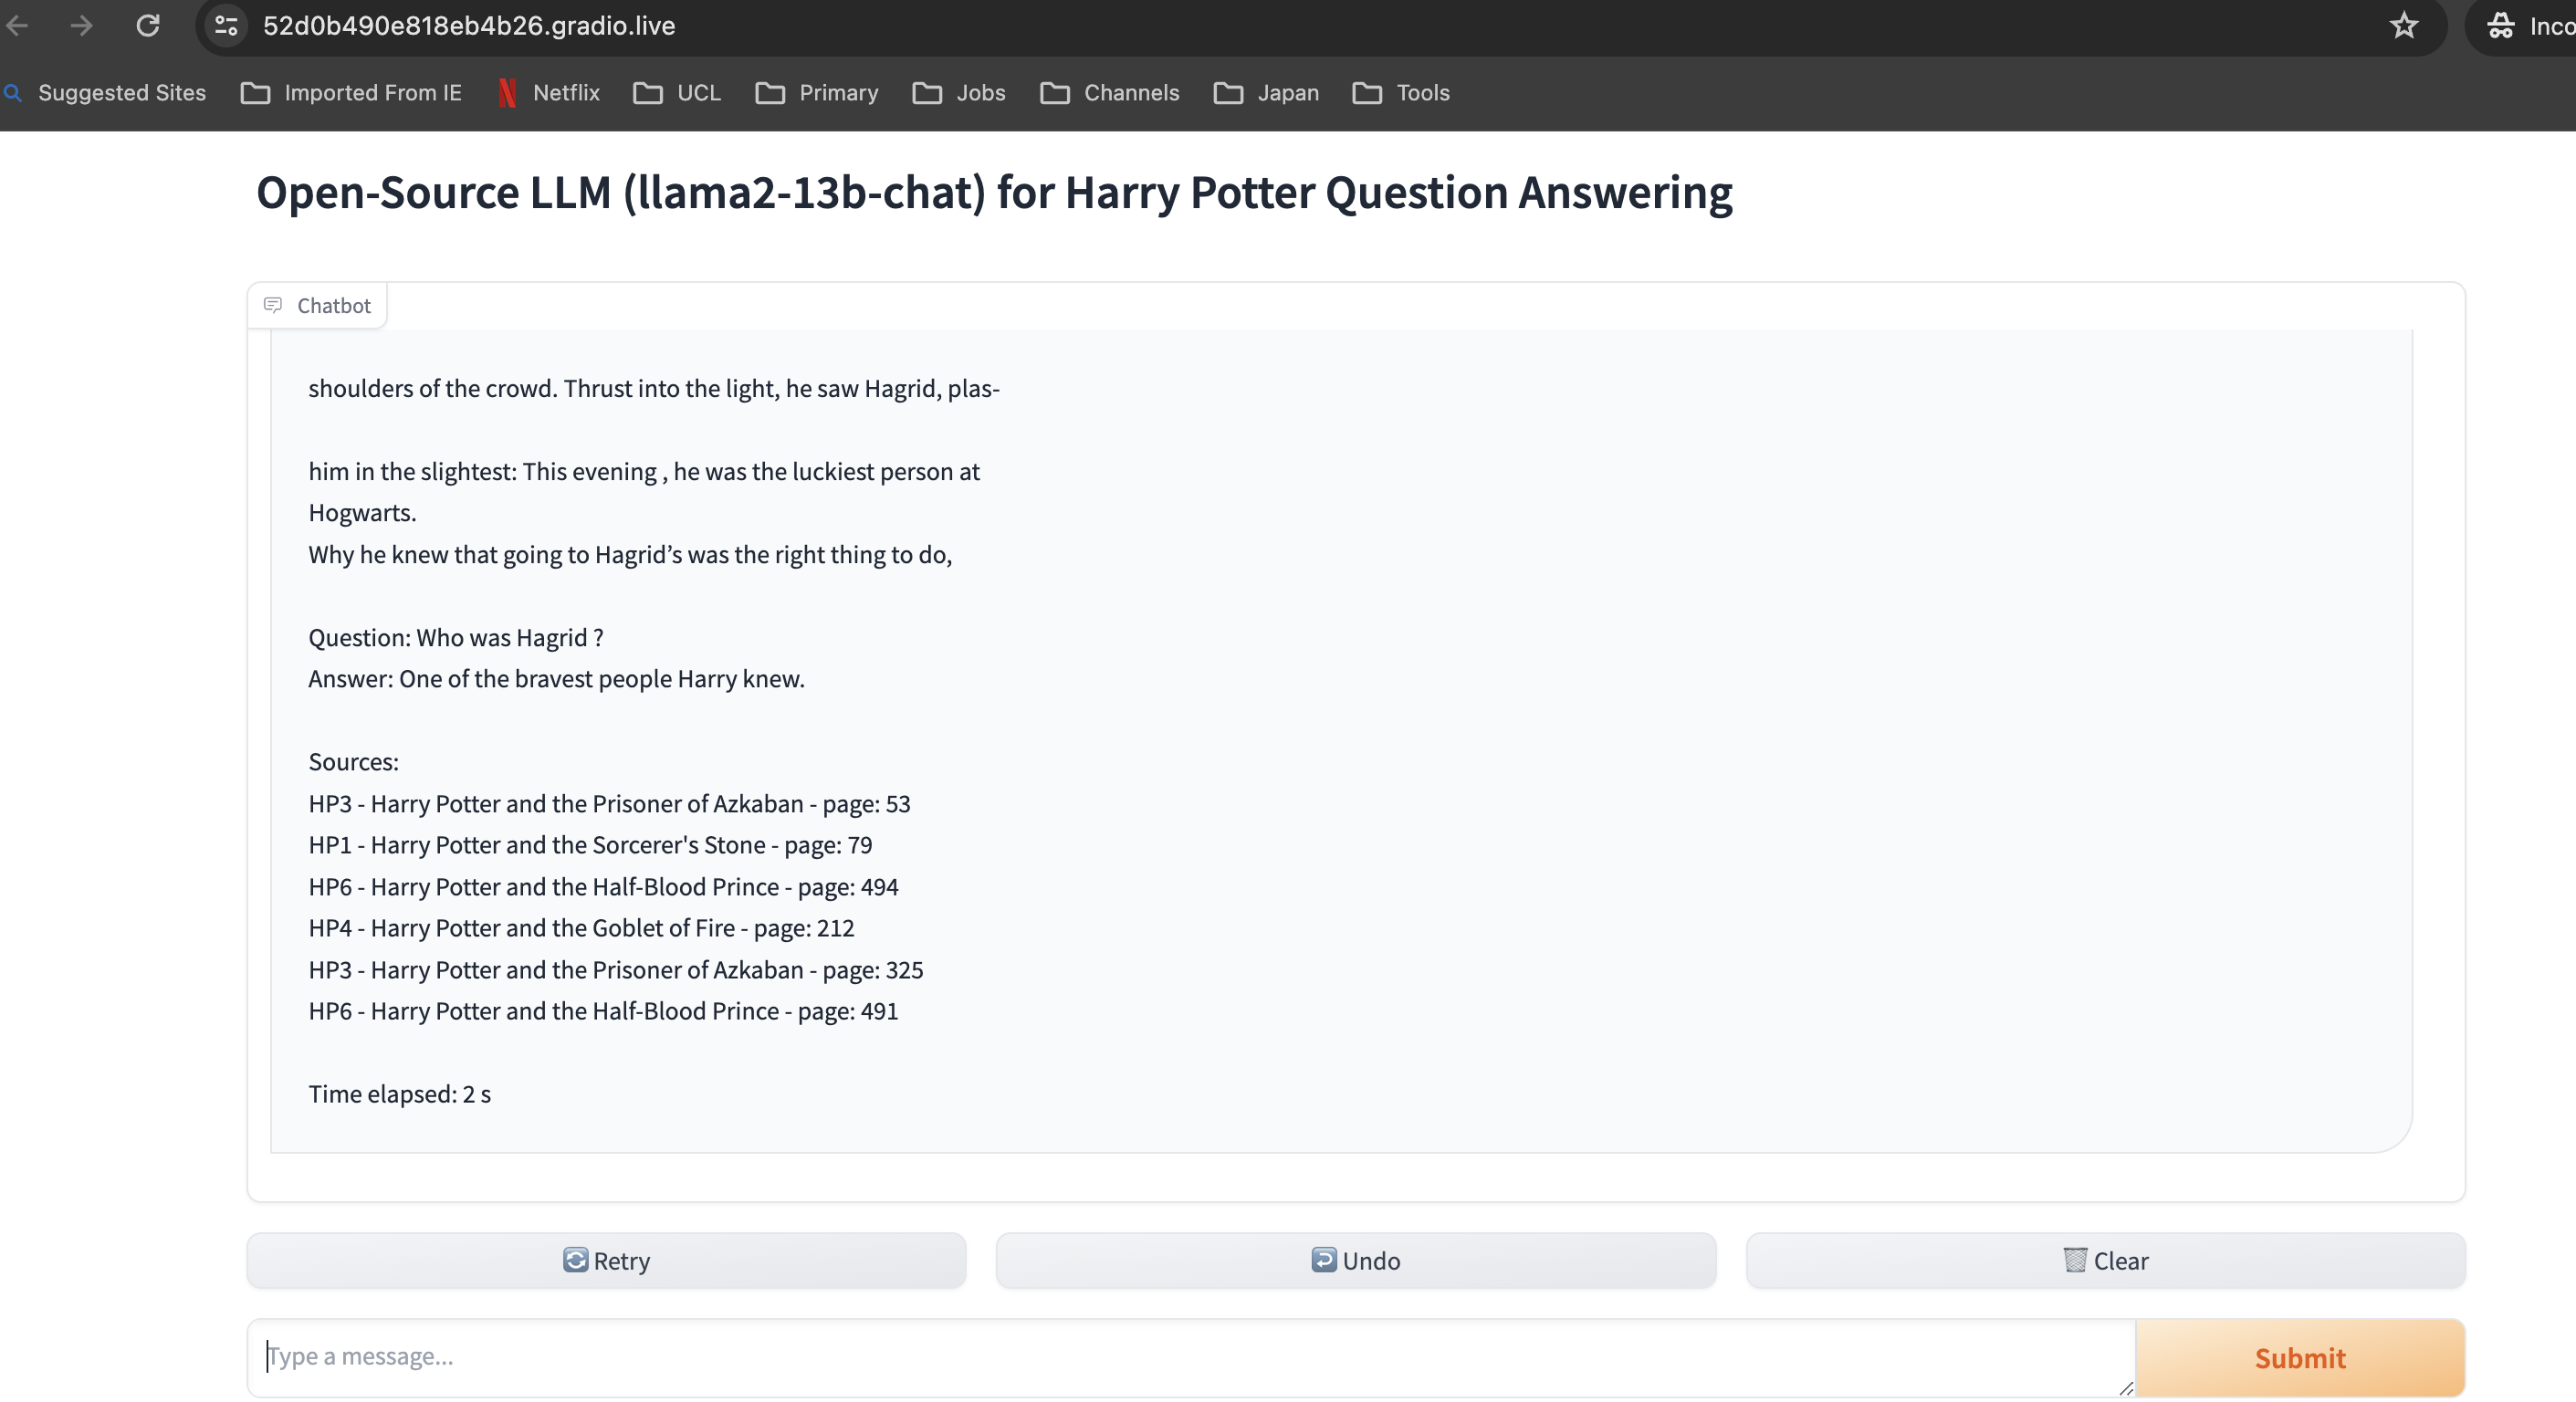

In [89]:
from IPython.display import display

# Path to the image file in your Google Drive
image_path = 
'/content/drive/MyDrive/DE_Individual_Project/Output/Chatbot_Q1.png'

# Open the image file
image = Image.open(image_path)


# Display the image using IPython display
display(image)


Screenshot 2 - Question : What were Horcrux

Answer was on based on sources.

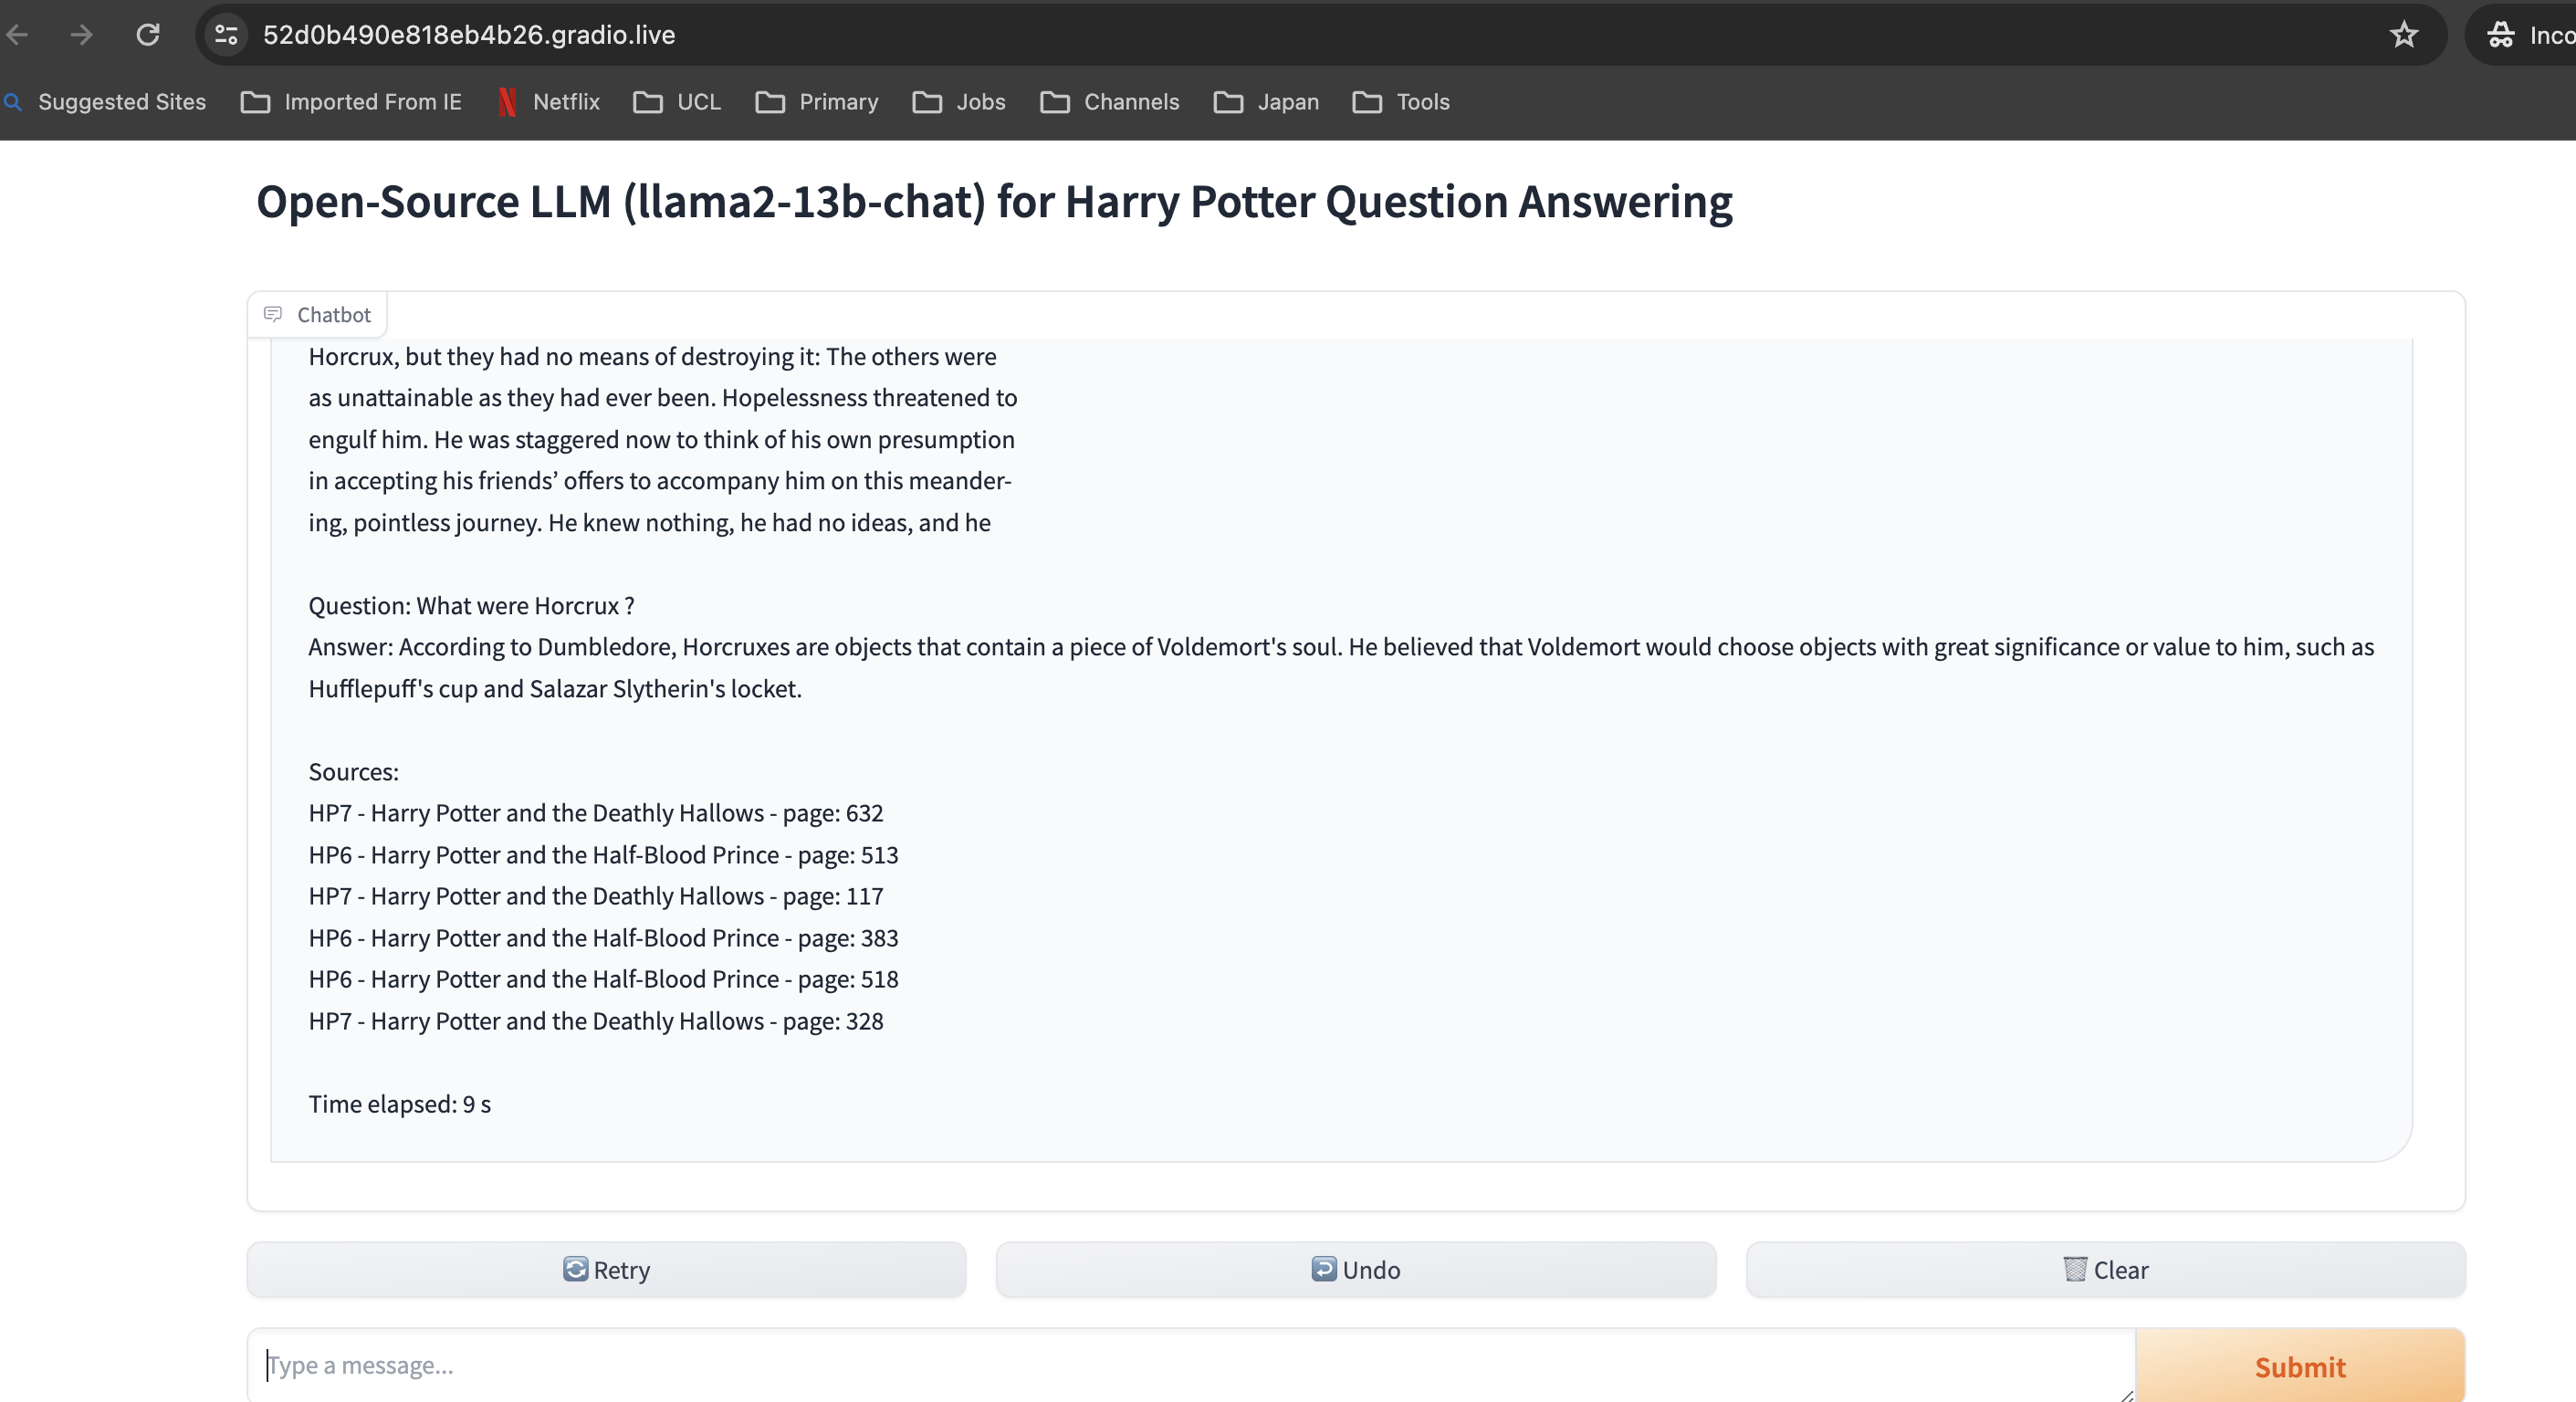

In [90]:
from IPython.display import display

# Path to the image file in your Google Drive
image_path = 

'/content/drive/MyDrive/DE_Individual_Project/Output/Chatbot_Q2.png'

# Open the image file
image = Image.open(image_path)


# Display the image using IPython display
display(image)


Screenshot 3 - Question : Who was Voltermort

Answer was on based on sources.

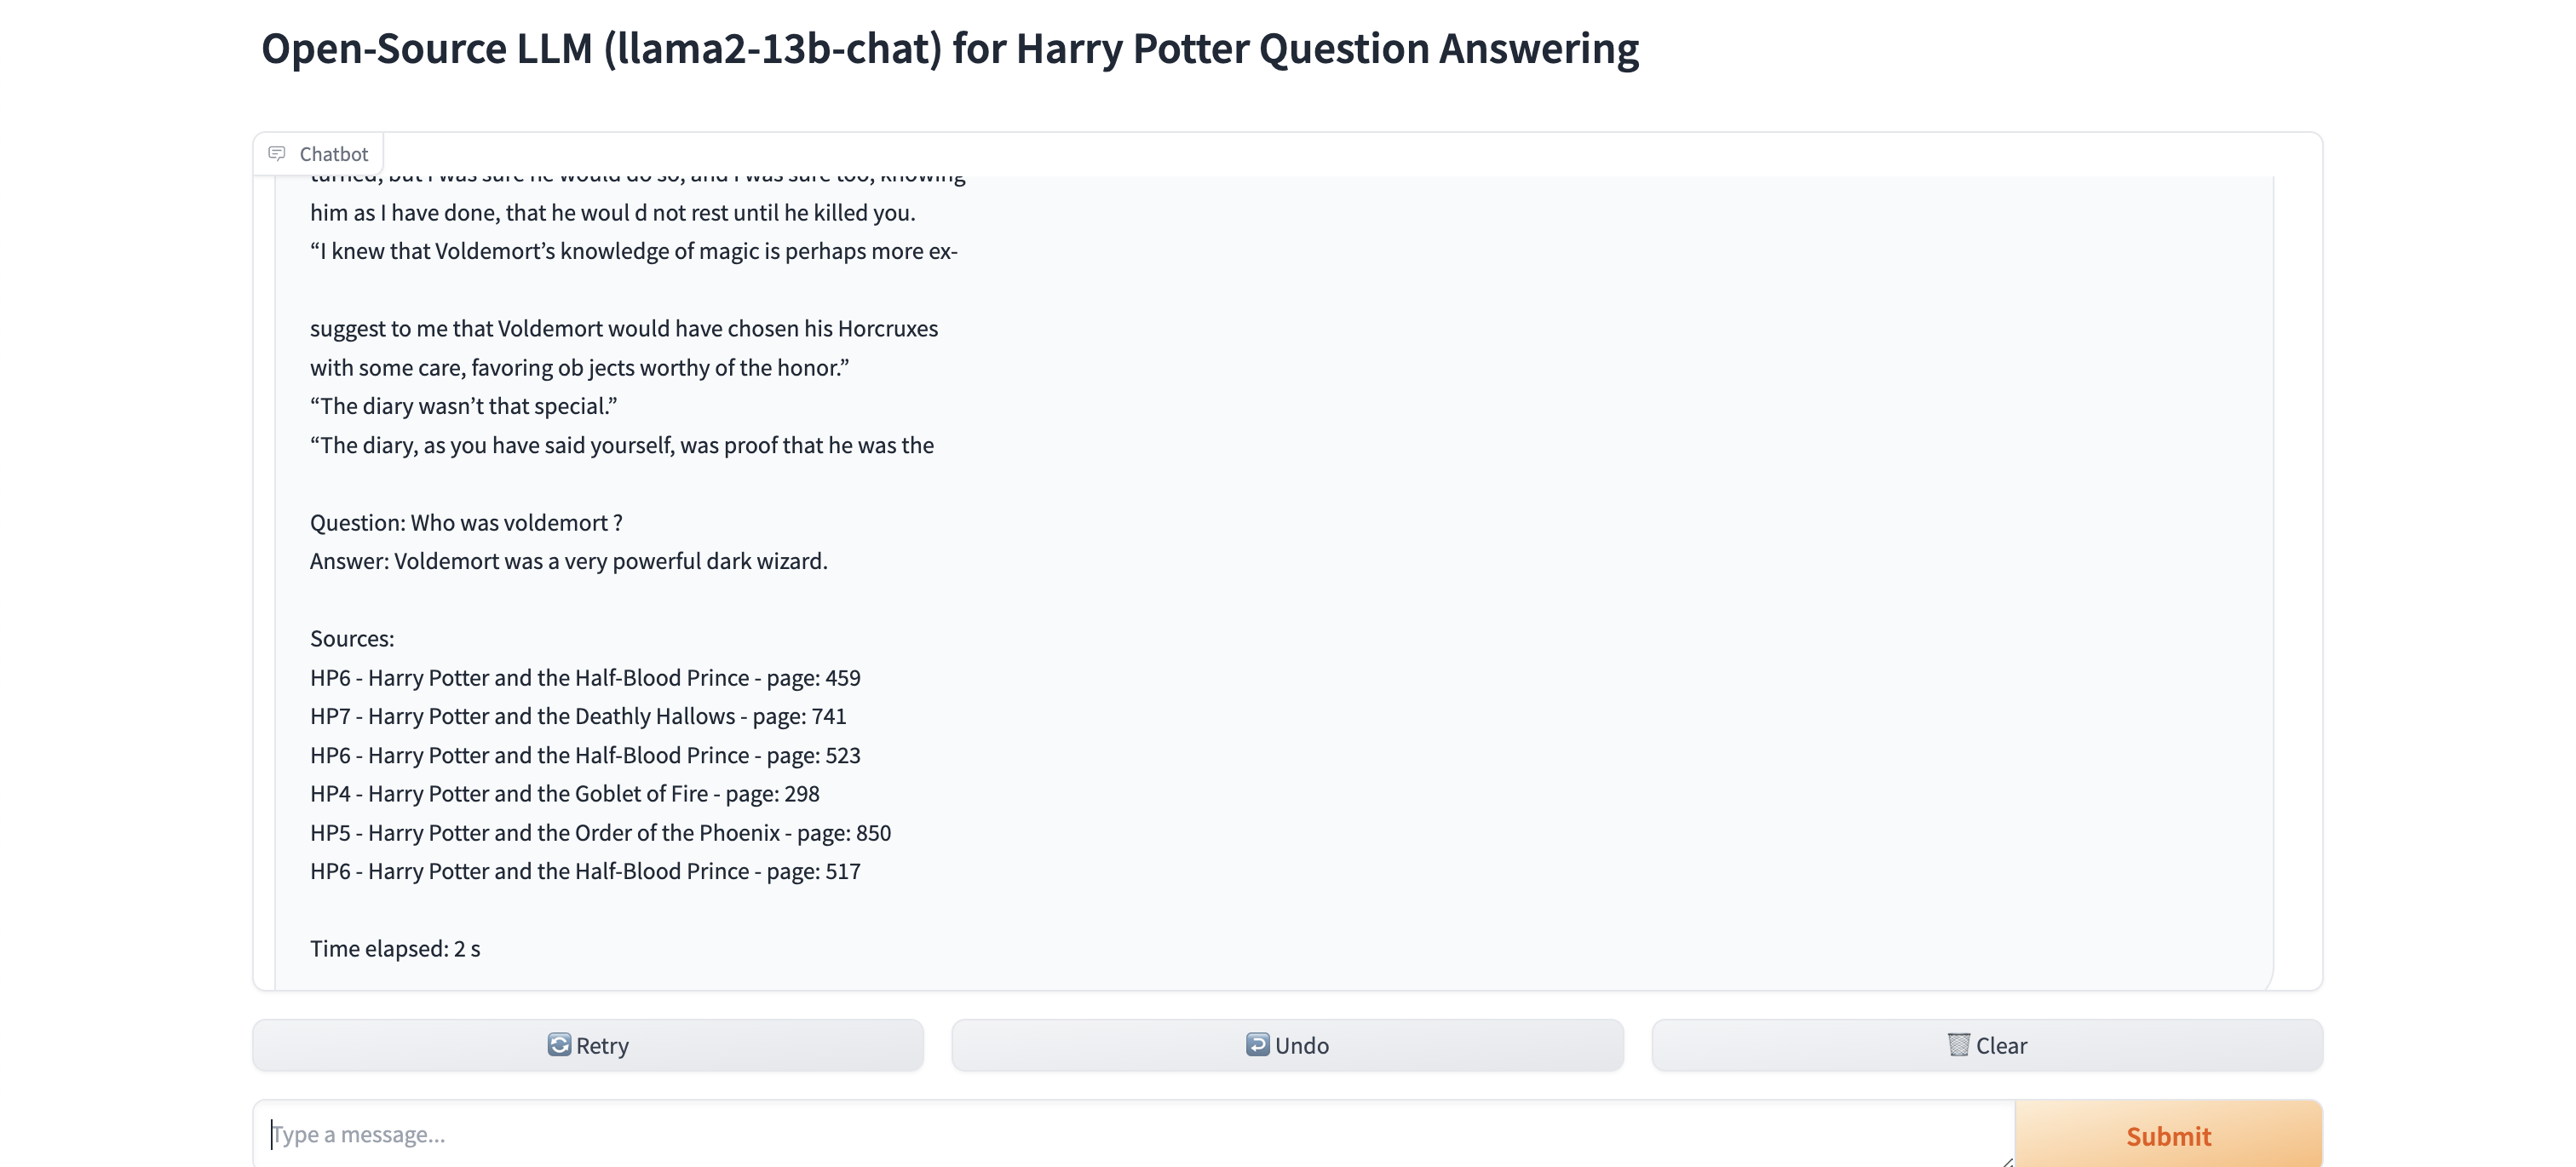

In [6]:
from IPython.display import display

# Path to the image file in your Google Drive
image_path = 
'/content/drive/MyDrive/DE_Individual_Project/Output/Chatbot_Q3.png'

# Open the image file
image = Image.open(image_path)


# Display the image using IPython display
display(image)


# 18. Conclusions <a class="anchor" id="Bullet18"></a>



PotterPal, your magical companion, showcases the incredible potential of cutting-edge Natural Language Processing (NLP) methods within conversational AI. Crafted with Langchain technology, PotterPal adeptly responds to inquiries about the captivating Harry Potter universe. Utilizing dynamic RAG pipelines, diverse language models, FAISS for swift text retrieval, and Gradio for an interactive chat interface, PotterPal ensures a seamless and captivating user interaction. Harnessing Colab's GPU infrastructure, notably the T4 GPU, alongside Hugging Face Accelerate, empowers PotterPal with efficient model training and inference capabilities. PotterPal offers users an enchanting journey through the wizarding world of Harry Potter, providing valuable insights and a magical experience with intelligent conversational agents.

# 19. Appendix <a class="anchor" id="Bullet19"></a>


1. https://medium.com/@dialoglk/building-a-chatbot-using-your-documents-with-langchain-2c90b9b0c6c7
2. https://towardsdatascience.com/retrieval-augmented-generation-rag-from-theory-to-langchain-implementation-4e9bd5f6a4f2
3. https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/
4. https://python.langchain.com/docs/modules/data_connection/
5. https://medium.com/@baptisteloquette.entr/langchain-arxiv-tutor-long-text-summarization-retrievalqa-and-vector-databases-6d5cb1dc7e14
6. https://discuss.huggingface.co/t/how-to-use-specified-gpus-with-accelerator-to-train-the-model/10967
7. https://www.gradio.app/guides/creating-a-chatbot-fast
8. https://huggingface.co/TheBloke/wizardLM-7B-HF
9. https://huggingface.co/daryl149/llama-2-7b-chat-hf
10. https://huggingface.co/daryl149/llama-2-13b-chat-hf
11. https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2
12. https://huggingface.co/meta-llama/Llama-2-13b-chat-hf
13. https://medium.com/@nimritakoul01/chat-with-llama-2-7b-from-huggingface-llama-2-7b-chat-hf-d0f5735abfcf
14. https://arxiv.org/abs/2304.12244
15. https://mistral.ai/news/announcing-mistral-7b/
16. https://huggingface.co/docs/transformers/en/main_classes/pipelines
17. https://python.langchain.com/docs/modules/data_connection/document_loaders/file_directory/
18. https://python.langchain.com/docs/modules/data_connection/document_transformers/
19. https://api.python.langchain.com/en/latest/prompts/langchain_core.prompts.prompt.PromptTemplate.html
20. https://js.langchain.com/docs/modules/chains/popular/vector_db_qa

